In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import umap
import keras
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from random import randrange
from keras import layers, regularizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

The models in this script are implemented using the "functional" API of Keras (as opposed to its "sequencial" API, [their differences](https://stackoverflow.com/a/58092554/947889)). 

Interesting blog posts:
- https://keras.io/examples/generative/vae/
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
- https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df

Overview: 

1. Load data; 
2. Split into dev, train, and eval sets;
3. normalize sets separately;

# Load, Normalize, and Split Data

Should data be normalized before or after they're split (see [this](https://datascience.stackexchange.com/a/27616/106388) and [this](https://stats.stackexchange.com/a/375183/269404)). We had a chat and agreed on normalizing data after the split.

In [18]:
 def get_data():
        """
        Load Data
        We load data into RAM since data is small and will fit in memory.
        :return:
        """

        columns_to_remove = ["CellID", "ERK1_2_nucleiMasks"]

        cells = pd.read_csv("../data/SARDANA.csv", header=0)

        # Keeps only the 'interesting' columns with morphological features

        morph_data = pd.DataFrame(
              columns=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "Solidity", "Extent",
                         "Orientation"])

        morph_data = cells.loc[:, morph_data.columns]
        cells = cells.filter(regex="nucleiMasks$", axis=1).filter(regex="^(?!(DAPI|AF))", axis=1)  # With morph data

            # Re add morph data
        for column in morph_data.columns:
            cells[f"{column}"] = morph_data[f"{column}"]

        if "Orientation" in cells.columns:
            cells['Orientation'] = cells["Orientation"].abs()

                
                # Remove not required columns
        for column in columns_to_remove:
            if column in cells.columns:
                del cells[f"{column}"]

        markers = cells.columns
        markers = [re.sub("_nucleiMasks", "", x) for x in markers]

        # return cells, markers
        return cells, markers

inputs, markers = get_data()
print(markers)
inputs.head()

['Hoechst0', 'Hoechst1', 'A488', 'A555', 'A647', 'Hoechst2', 'anti_CD3', 'anti_NaKATPase', 'anti_CD45RO', 'Hoechst3', 'Ki67_488', 'Keratin_570', 'aSMA_660', 'Hoechst4', 'CD4_488', 'CD45_PE', 'PD1_647', 'Hoechst5', 'CD20_488', 'CD68_555', 'CD8a_660', 'Hoechst6', 'CD163_488', 'FOXP3_570', 'PDL1_647', 'Hoechst7', 'Ecad_488', 'Vimentin_555', 'CDX2_647', 'Hoechst8', 'LaminABC_488', 'Desmin_555', 'CD31_647', 'Hoechst9', 'PCNA_488', 'Ki67_570', 'CollagenIV_647', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation']


,Hoechst0_nucleiMasks,Hoechst1_nucleiMasks,A488_nucleiMasks,A555_nucleiMasks,A647_nucleiMasks,Hoechst2_nucleiMasks,anti_CD3_nucleiMasks,anti_NaKATPase_nucleiMasks,anti_CD45RO_nucleiMasks,Hoechst3_nucleiMasks,...,PCNA_488_nucleiMasks,Ki67_570_nucleiMasks,CollagenIV_647_nucleiMasks,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,4974.591973,295.638796,788.926421,356.782609,760.210702,321.869565,945.464883,506.508361,321.170569,247.889632,...,1412.779264,1105.769231,414.969900,299,24.879021,17.129036,0.725243,0.884615,0.619048,0.960565
1,5168.692308,292.789011,782.676923,350.659341,749.257143,325.131868,945.268132,500.786813,318.938462,254.063736,...,1401.883516,1090.821978,421.769231,455,29.872326,20.996925,0.711300,0.834862,0.677083,1.466225
2,1950.133333,912.186667,1137.400000,430.293333,771.693333,8101.160000,1604.000000,830.213333,346.173333,9718.026667,...,1161.613333,990.680000,380.413333,75,12.642613,7.613372,0.798346,0.974026,0.721154,1.524043
3,4150.808642,273.179012,723.512346,337.141975,745.685185,371.345679,923.253086,504.456790,352.567901,305.888889,...,1191.080247,975.407407,407.030864,162,22.302877,9.652477,0.901494,0.925714,0.736364,1.504132
4,4192.787356,288.494253,773.258621,356.287356,757.500000,323.028736,934.798851,509.804598,312.908046,247.936782,...,1385.626437,1083.655172,413.172414,174,16.190759,14.112215,0.490179,0.961326,0.682353,1.115873


In [19]:
def normalize(data):    
    # Input data contains some zeros which results in NaN (or Inf)
    # values when their log10 is computed. NaN (or Inf) are problematic
    # values for downstream analysis. Therefore, zeros are replaced by 
    # a small value; see the following thread for related discussion.
    # https://www.researchgate.net/post/Log_transformation_of_values_that_include_0_zero_for_statistical_analyses2
    data[data==0] = 1e-32
    data = np.log10(data)
    
    standard_scaler = StandardScaler()
    data = standard_scaler.fit_transform(data)
    data = data.clip(min=-5, max=5)
    
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    data = min_max_scaler.fit_transform(data)
    return data

inputs = np.array(inputs)
# random_state is a random seed to have a reproducible shuffling (only for dev purpose).
X_dev,   X_val  = train_test_split(inputs, test_size=0.05, random_state=1, shuffle=True)
X_train, X_test = train_test_split(X_dev,  test_size=0.25, random_state=1, shuffle=True)

# This is primarily for the purpose of 
# being able to see how much data is removed
# (as part of outlier removal) and plot
# the changes in data distribution.
init_inputs = inputs
init_X_train = X_train
init_X_test = X_test
init_X_val = X_val

inputs = normalize(inputs)
X_train = normalize(X_train)
X_test = normalize(X_test)
X_val = normalize(X_val)

## Get an Overview of the Data

In [20]:
def get_percentage(new_num, org_num):
    return round((new_num * 100) / org_num, 2)


print(f"                    Input Shape:\t{init_inputs.shape}\t[{init_inputs.shape[0]}] Cells and [{init_inputs.shape[1]}] Markers\n")
print(f"Input size before normalization:\t{init_inputs.shape}")
print(f"Input size after  normalization:\t{inputs.shape}")
print(f"        Removed data percentage:\t{100 - get_percentage(inputs.shape[0], init_inputs.shape[0])}%")
print("")
print(f"                Train data size:\t{X_train.shape}\t({get_percentage(init_X_train.shape[0], init_inputs.shape[0])}% of input)")
print(f"                 Test data size:\t{X_test.shape}\t({get_percentage(init_X_test.shape[0], init_inputs.shape[0])}% of input)")
print(f"           Validation data size:\t{X_val.shape}\t({get_percentage(init_X_val.shape[0], init_inputs.shape[0])}% of input)")

# NOTE: the number of cells in X_train, X_test, and X_val would NOT
# add up to the number of cells in inputs if outliers are removed. 
# It is because outliers are removed after the cells in inputs 
# is split between train, test, and val sets.

                    Input Shape:	(725877, 44)	[725877] Cells and [44] Markers

Input size before normalization:	(725877, 44)
Input size after  normalization:	(725877, 44)
        Removed data percentage:	0.0%

                Train data size:	(517187, 44)	(71.25% of input)
                 Test data size:	(172396, 44)	(23.75% of input)
           Validation data size:	(36294, 44)	(5.0% of input)


## Some Checkes on the Normalized Data

In [21]:
rnd = randrange(0, inputs.shape[1])
# Mean should be zero and standard deviation 
# should be 1. However, due to some challenges 
# relationg to floating point positions and rounding, 
# the values should be very close to these numbers.
# For details, see:
# https://stackoverflow.com/a/40405912/947889
# Hence, we assert the rounded values.
print(inputs[:,rnd].std())
print(inputs[:,rnd].mean())

0.1931355345336943
-0.0009154114867337842


## Plot Normalized Data Distributions

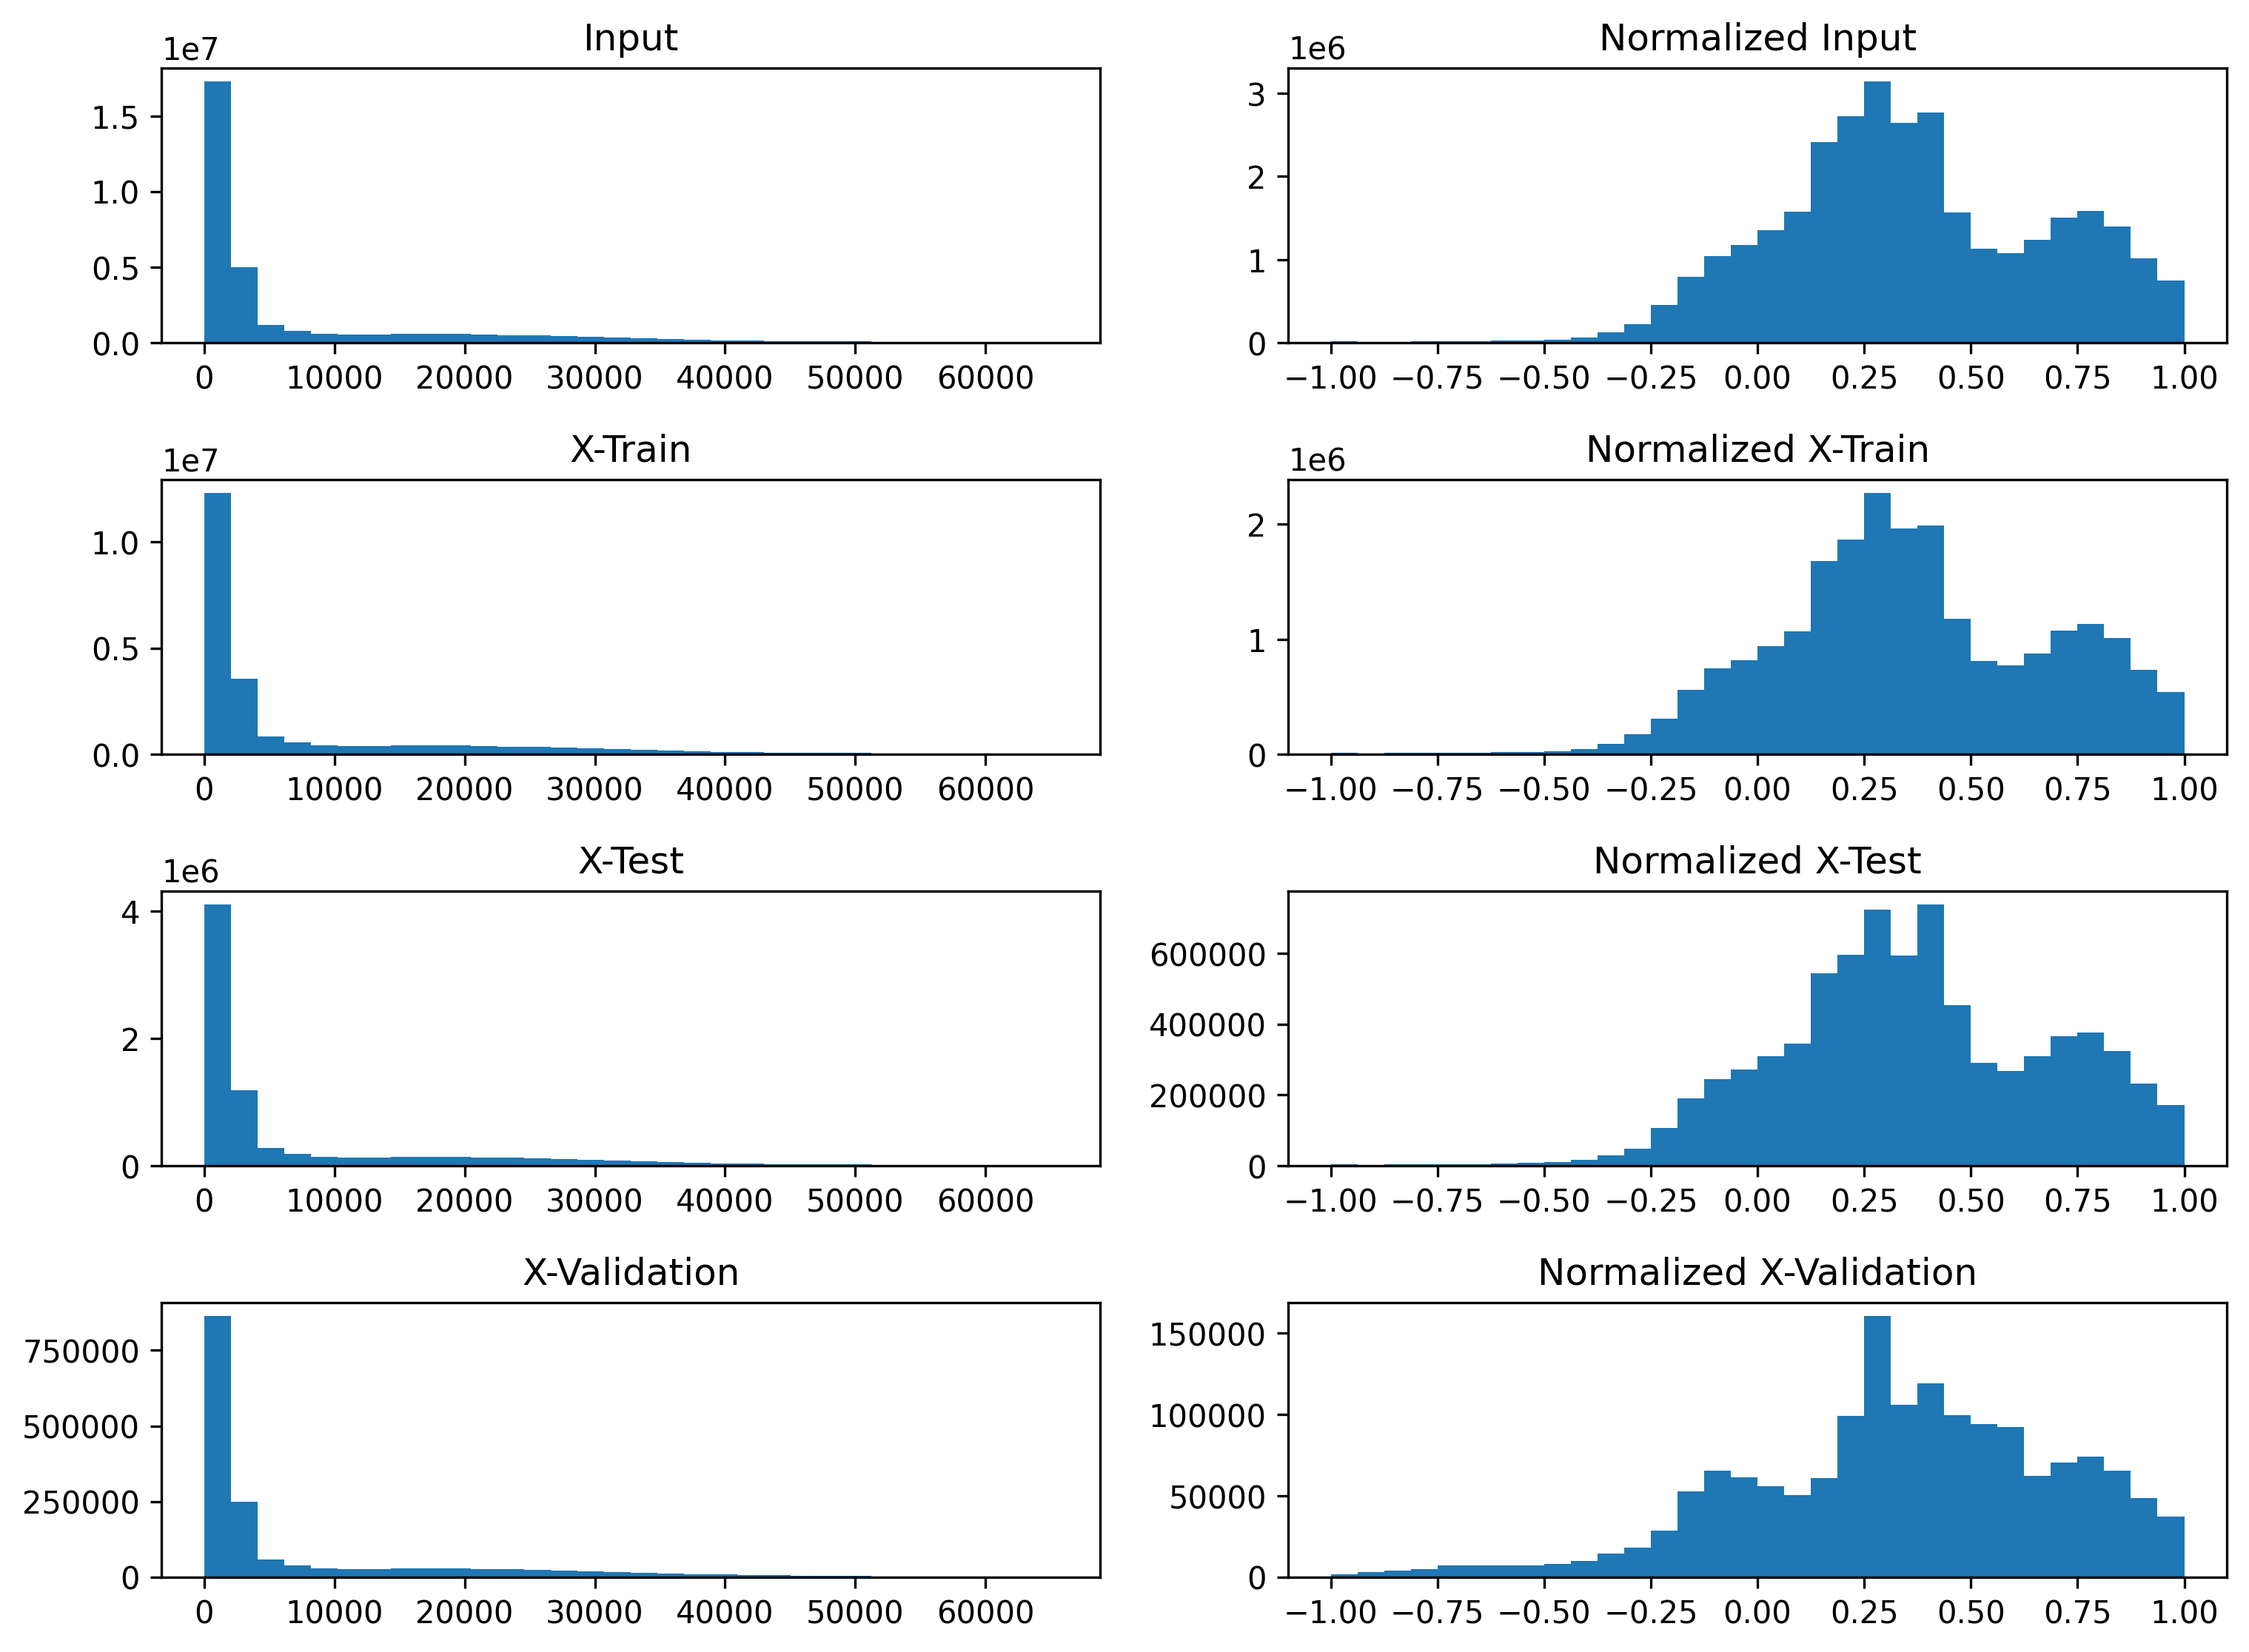

In [22]:
def plot_dists(ax, data, title, plot_type=""):
    # Flatten data, `ravel` yields a 1D "view",
    # which is more efficient than creating a 1D copy.
    f_data = data.ravel()
    
    if plot_type == "density":
        density = stats.gaussian_kde(f_data)
        n, x, _ = plt.hist(f_data, bins=25, histtype="step", density=True)
        ax.plot(x, density(x))
    elif plot_type == "both":
        density = stats.gaussian_kde(f_data)
        n, x, _ = ax.hist(f_data, bins=25, histtype="bar", density=True)
        ax.plot(x, density(x))
    else:
        ax.hist(f_data, bins=32, histtype="bar")
    ax.set_title(title)
    #ax.set_yscale('log')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 9), dpi=300)
plt.subplots_adjust(wspace=0.20, hspace=0.50)
plot_dists(axs[0, 0], init_inputs, "Input")
plot_dists(axs[0, 1], inputs, "Normalized Input")
plot_dists(axs[1, 0], init_X_train, "X-Train")
plot_dists(axs[1, 1], X_train, "Normalized X-Train")
plot_dists(axs[2, 0], init_X_test, "X-Test")
plot_dists(axs[2, 1], X_test, "Normalized X-Test")
plot_dists(axs[3, 0], init_X_val, "X-Validation")
plot_dists(axs[3, 1], X_val, "Normalized X-Validation")
plt.show()